# Introduction
## Goal.
The goal of this lab is to investigate, by means of agent-based simulations, an example
of Evolutionary Robotics. In particular, we will focus on a maze navigation robot task, and see
how Evolutionary Algorithms can be used to solve this problem.

Note once again that, unless otherwise specified, in this module’s exercises we will use real-valued
genotypes and that the aim of the algorithms will be to minimize the fitness function $f(x)$, i.e.
lower values correspond to a better fitness!

# Exercise 1
In this exercise we will perform an Evolutionary Robotics experiment to evolve the controller of a robot navigating a certain environment. This task is usually referred to as “maze navigation”. In principle, this kind of experiments can be done in hardware, i.e. with physical robots and a physical arena (this kind of approach is usually called embodied evolution). While embodied evolution is a quite powerful approach, it also presents several challenges due to limited battery lifetime, hardware issues/faults, costs, time-consuming experiments, etc. Here, for simplicity we will perform similar experiments in silico, i.e. by means of agent-based simulations. Note however that this is actually the typical approach used in Evolutionary Robotics, where usually simulations are performed first, and then the simulated experiments are replicated in materio (i.e. with physical hardware), to assess the so-called “reality-gap” and validate the solution.

Here, we will perform simplified 2-D kinematic simulations of a maze navigation task performed by an agent represented by a car.

The task is to drive from the bottom left of the map to the green zone in the upper right corner.
The car is equipped with 6 sensors: distance and bearing to the target position and, optionally, 4 lidar sensors. 
The first two return the distance and the angle between the car and the target. The lidars return the distance between the car and a possible obstacle in the range $[0,1]$. Hence, a value of $1$ indicates that there are no obstacles in the range of the lidar ($100$ pixels).
Instead, if a lidar returns $0$ it indicates that the car is colliding with an obstacle. 

A Feed Forward Neural Network (FFNN) moves the car on the map. The FFNN has $2$ or $6$ inputs, depending on if the lidars are activated, and $5$ outputs. The agent selects the action by the argmax of the outputs, and the possible actions are: turn left or right, accelerate or decelerate, and stop the car. 
The hidden structure of the network is composed of $l$ layers of $n$ nodes, where $l$ and $n$ are configurable parameters. 

The evolutionary algorithm has to optimize the weights of the FFNN, and the total number of parameters is $inputs \times n + l \times n^2 + n \times outputs$ if $n>=1$ else $inputs \times  outputs$. 
All the network’s weights range in $[−3, 3]$.

This script will perform a maze navigation Evolutionary Robotics experiment in a first scenario (environment without obstacles). This experiment uses an Evolutionary Algorithm to evolve the synaptic weights of the described Neural Network. The synaptic weights, which represent the genes of the individuals, are coded using real-coded values (floating point). A population of such individuals is evolved, using tournament selection, Gaussian mutation, n-point crossover,
and elitism (see exercise_maze.py for more details about the algorithmic configuration and parametrization). The genotypes of the first generation are initialized randomly in the range $[-3,3]$. Elitism is used to make sure that good solutions are not lost because of mutation or crossover, while the rest of the population is generated by means of the genetic operators. At each generation, the genotypes (i.e., the encoded controllers) generated by the EA are sent to the simulator (one batch per generation), which then translates the genotypes it receives into a set of Neural Network controllers, evaluates the controllers and sends the fitness back to the EA. 
At the end of the evolutionary process, the script will save a pickle containg the best genome (file best_seed.pkl, where seed is the seed used) found, and other information needed to run the simulation a posteriori.
You can “replay” the best candidate, by running this command:

``python3 post_eval.py best.pkl``

where ``best.pkl`` is the path to the pickle file.

---

Design and implement a fitness function that would allow the robot to reach the target as fast as possible. To do so, you can modify the function ``fitness_eval`` coded in the next cell. Five metrics are computed by the simulator and can be used to devise different fitness functions, namely:
- *distanceToTarget*: the distance to target at the end of the simulation (default);
- *pathLength*: the total distance traveled by the robot;
- *noOfTimestepsWithCollisions*: the no. of timesteps when the robot had a collision with an obstacle or a wall (ranging in [0,250]);
- *timestepToReachTarget*: the no. of timesteps needed for the robot to reach the target (ranging in [0,250]);
- *timestepsOnTarget*: the no. of timesteps spent by the robot on the target (ranging in [0,250]);

By using one or more of these five quantities properly into one single fitness value, different robot behaviors can be evolved. Please note that, by default, the RobotEvaluator is formulated as a minimization problem (see the flag ``maximize = False``). However, if you deem it more appropriate, you can change the flag to turn it into a maximization problem. 
**NOTE**: While you design the fitness function, be careful about divisions by zero and make sure that when you divide one integer variable by another you cast your variables to float, to avoid unexpected behaviors due to integer divisions.

- Is the Evolutionary Algorithm able to evolve a Neural Network controller that can reach the target? What kind of motion strategy does it use?
- What is the minimum-complexity Neural Network controller that you can think of? Hint: think about the necessity of using all the available sensor inputs in this case, and if any of them can be discarded (see the configuration dictionary to disable inputs). Also, consider reducing the no. if hidden nodes and test different network configurations to identify the simplest controller.
- By looking at the weights of the best evolved Neural Network in the simplest case you just found, can you try to make sense of the controller functioning? (Note that weights appear ordered by layer and, for each layer, by node.)

Defaulting to user installation because normal site-packages is not writeable
Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         0         10 1837.88191 269.365768 1730.15643 1391.89376 519.698695

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         1         20 1747.88831 269.365768 1446.32427 1237.92323 478.336122

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         2         30 1747.88831 269.365768 1138.50910 1197.68234 511.432207

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         3         40 1446.32427 121.761874 830.693941 765.230950 339.67

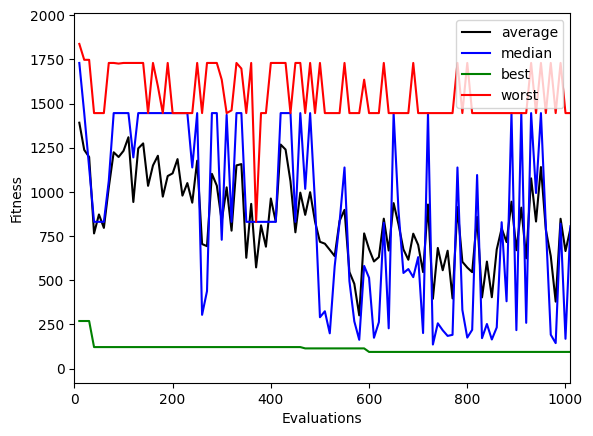

In [15]:
!pip3 install pygame
from utils.utils_9.exercise_maze import *
import os 

# --------------------------------------------------------------------------- #
# Change this part, but not the map

def fitness_eval(distanceToTarget, pathLength, noOfTimestepsWithCollisions,
                 timestepToReachTarget, timestepsOnTarget):
    mult = 0.3
    # lower fitness is better
    fitness = distanceToTarget + pathLength + noOfTimestepsWithCollisions * mult + timestepToReachTarget * mult + timestepsOnTarget * mult
    return fitness

config = {"sensors": False,
            "nrHiddenNodes":  7,
            "nrHiddenLayers": 2,
            "map":"white.png"
         }
seed = 0
rng = NumpyRandomWrapper(seed)

# --------------------------------------------------------------------------- #
# EA configuration
display = True

popSize = 10  # population size
numGen = 100  # used with generation_termination
numEval = 2500  # used with evaluation_termination
tournamentSize = 2  # tournament size (default 2)
mutationRate = 0.5  # mutation rate, per gene (default 0.1)
gaussianMean = 0  #  mean of the Gaussian distribution used for mutation
gaussianStdev = 0.1  #  std. dev. of the Gaussian distribution used for mutation
crossoverRate = 1.0  # rate at which crossover is performed (default 1.0)
numCrossoverPoints = 1  # number of crossover points used (default 1)
selectionSize = popSize  # selection size (i.e. how many individuals are selected for reproduction)
numElites = 2  # no. of elites (i.e. best individuals that are kept in the population)

# the evolutionary algorithm (EvolutionaryComputation is a fully configurable evolutionary algorithm)
#  standard GA, ES, SA, DE, EDA, PAES, NSGA2, PSO and ACO are also available
ea = inspyred.ec.EvolutionaryComputation(rng)

# observers: provide various logging features
if display:
    ea.observer = [inspyred.ec.observers.stats_observer,
                   plot_observer]
    # inspyred.ec.observers.file_observer,
    # inspyred.ec.observers.best_observer,
    # inspyred.ec.observers.population_observer,

#  selection operator
# ea.selector = inspyred.ec.selectors.truncation_selection
# ea.selector = inspyred.ec.selectors.uniform_selection
# ea.selector = inspyred.ec.selectors.fitness_proportionate_selection
# ea.selector = inspyred.ec.selectors.rank_selection
ea.selector = inspyred.ec.selectors.tournament_selection

# variation operators (mutation/crossover)
ea.variator = [inspyred.ec.variators.gaussian_mutation,
               inspyred.ec.variators.n_point_crossover]
# inspyred.ec.variators.random_reset_mutation,
# inspyred.ec.variators.inversion_mutation,
# inspyred.ec.variators.uniform_crossover,
# inspyred.ec.variators.partially_matched_crossover,

# replacement operator
# ea.replacer = inspyred.ec.replacers.truncation_replacement
# ea.replacer = inspyred.ec.replacers.steady_state_replacement
# ea.replacer = inspyred.ec.replacers.random_replacement
# ea.replacer = inspyred.ec.replacers.plus_replacement
# ea.replacer = inspyred.ec.replacers.comma_replacement
# ea.replacer = inspyred.ec.replacers.crowding_replacement
# ea.replacer = inspyred.ec.replacers.simulated_annealing_replacement
# ea.replacer = inspyred.ec.replacers.nsga_replacement
# ea.replacer = inspyred.ec.replacers.paes_replacement
ea.replacer = inspyred.ec.replacers.generational_replacement

# termination condition
# ea.terminator = inspyred.ec.terminators.evaluation_termination
# ea.terminator = inspyred.ec.terminators.no_improvement_termination
# ea.terminator = inspyred.ec.terminators.diversity_termination
# ea.terminator = inspyred.ec.terminators.time_termination
ea.terminator = inspyred.ec.terminators.generation_termination

# --------------------------------------------------------------------------- #

# the robot maze navigation problem
problem = RobotEvaluator(config, seed, eval_func=fitness_eval, maximize=False)

args = {}
args["fig_title"] = "EA"

# run the EA
final_pop = ea.evolve(generator=problem.generator,
                      evaluator=problem.evaluator,
                      bounder=problem.bounder,
                      maximize=problem.maximize,
                      pop_size=popSize,
                      max_generations=numGen,
                      # max_evaluations=numEval,
                      tournament_size=tournamentSize,
                      mutation_rate=mutationRate,
                      gaussian_mean=gaussianMean,
                      gaussian_stdev=gaussianStdev,
                      crossover_rate=crossoverRate,
                      num_crossover_points=numCrossoverPoints,
                      num_selected=selectionSize,
                      num_elites=numElites, **args)

# --------------------------------------------------------------------------- #
best_candidate = final_pop[0].candidate
best_fitness = final_pop[0].fitness
os.makedirs("results", exist_ok=True)
pickle.dump(([best_candidate], "utils/utils_9/"+config["map"], config, True), open("results/best_"+str(seed)+".pkl", "wb"))

In [16]:
import os
os.popen("python3 post_eval.py results/best_0.pkl").read()

''

# Exercise 2
Let us consider now a second scenario (environment with obstacles). To do so, change in the
configuration dict the parameter map to be ``hard.png``.
First of all, it is interesting to see if the controller evolved in the previous exercise is able to generalize its functioning to this case.
- Take the best Neural Network evolved in the previous exercise and run it in the new scenario, running the next cell.
- What happens in this case? Is the best Neural Network evolved in the previous exercise able to generalize to this new environment? Why?

In [17]:
import pickle

best_path = "results/best_0.pkl"
data = pickle.load(open(best_path, "rb"))
new_data = (data[0], "utils/utils_9/hard.png", data[2], True)
pickle.dump(new_data, open("results/tmp.pkl", "wb"))

os.popen("python3 post_eval.py results/tmp.pkl").read()

''

Consider now running a new evolutionary process from scratch, to evolve a controller specific for this new, somehow harder environment.

- Is the same fitness function you designed in the previous exercise able to guide the evolutionary search also in this case? If not, try to change it appropriately (Hint: you may want to embed in the fitness value multiple metrics, and use some weights if needed). Does the best individual evolved in this scenario generalize to the first scenario?

- Try to make the problem even harder, in the attempt to find a controller that is able to drive the robot to the target without touching any walls. What kind of fitness function could you use in this case? You may also want to consider changing the configuration/parameters of the EA (e.g. larger population, higher number of generations, different mutation/crossover parameters) and/or the architecture/parameters of the Neural Network (e.g. add more hidden nodes).

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         0         10 1762.53368 1360.41354 1717.55701 1592.69029 191.422640

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         1         20 1672.58034 1360.41354 1483.68589 1500.95648 139.396711

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         2         30 1672.58034 1177.23107 1360.41354 1397.96644 129.205349

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         3         40 1762.53368 1177.23107 1360.41354 1409.37781 148.964307

Generation Evaluation      Worst       Best     Median    Average    Std

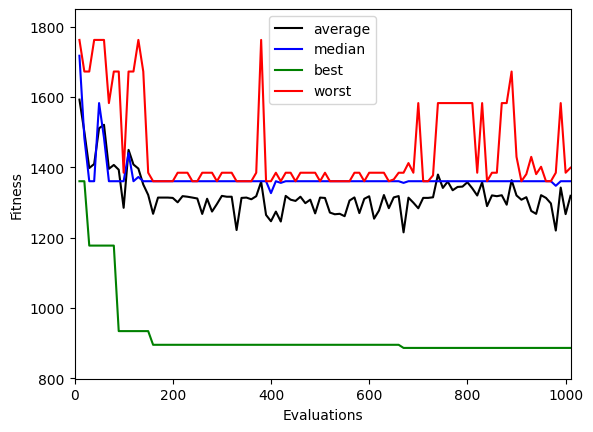

In [18]:
from utils.utils_9.exercise_maze import *
import os 

# --------------------------------------------------------------------------- #
# Change this part, but not the map

def fitness_eval(distanceToTarget, pathLength, noOfTimestepsWithCollisions,
                 timestepToReachTarget, timestepsOnTarget):
    fitness = distanceToTarget
    return fitness

config = {"sensors": False,
            "nrHiddenNodes":  10,
            "nrHiddenLayers": 3,
            "map":"hard.png"
         }
seed = 0
rng = NumpyRandomWrapper(seed)

# --------------------------------------------------------------------------- #
# EA configuration
display = True

popSize = 10  # population size
numGen = 100 # used with generation_termination
numEval = 2500  # used with evaluation_termination
tournamentSize = 2  # tournament size (default 2)
mutationRate = 0.5  # mutation rate, per gene (default 0.1)
gaussianMean = 0  #  mean of the Gaussian distribution used for mutation
gaussianStdev = 0.1  #  std. dev. of the Gaussian distribution used for mutation
crossoverRate = 1.0  # rate at which crossover is performed (default 1.0)
numCrossoverPoints = 1  # number of crossover points used (default 1)
selectionSize = popSize  # selection size (i.e. how many individuals are selected for reproduction)
numElites = 1  # no. of elites (i.e. best individuals that are kept in the population)

# the evolutionary algorithm (EvolutionaryComputation is a fully configurable evolutionary algorithm)
#  standard GA, ES, SA, DE, EDA, PAES, NSGA2, PSO and ACO are also available
ea = inspyred.ec.EvolutionaryComputation(rng)

# observers: provide various logging features
if display:
    ea.observer = [inspyred.ec.observers.stats_observer,
                   plot_observer]
    # inspyred.ec.observers.file_observer,
    # inspyred.ec.observers.best_observer,
    # inspyred.ec.observers.population_observer,

#  selection operator
# ea.selector = inspyred.ec.selectors.truncation_selection
# ea.selector = inspyred.ec.selectors.uniform_selection
# ea.selector = inspyred.ec.selectors.fitness_proportionate_selection
# ea.selector = inspyred.ec.selectors.rank_selection
ea.selector = inspyred.ec.selectors.tournament_selection

# variation operators (mutation/crossover)
ea.variator = [inspyred.ec.variators.gaussian_mutation,
               inspyred.ec.variators.n_point_crossover]
# inspyred.ec.variators.random_reset_mutation,
# inspyred.ec.variators.inversion_mutation,
# inspyred.ec.variators.uniform_crossover,
# inspyred.ec.variators.partially_matched_crossover,

# replacement operator
# ea.replacer = inspyred.ec.replacers.truncation_replacement
# ea.replacer = inspyred.ec.replacers.steady_state_replacement
# ea.replacer = inspyred.ec.replacers.random_replacement
# ea.replacer = inspyred.ec.replacers.plus_replacement
# ea.replacer = inspyred.ec.replacers.comma_replacement
# ea.replacer = inspyred.ec.replacers.crowding_replacement
# ea.replacer = inspyred.ec.replacers.simulated_annealing_replacement
# ea.replacer = inspyred.ec.replacers.nsga_replacement
# ea.replacer = inspyred.ec.replacers.paes_replacement
ea.replacer = inspyred.ec.replacers.generational_replacement

# termination condition
# ea.terminator = inspyred.ec.terminators.evaluation_termination
# ea.terminator = inspyred.ec.terminators.no_improvement_termination
# ea.terminator = inspyred.ec.terminators.diversity_termination
# ea.terminator = inspyred.ec.terminators.time_termination
ea.terminator = inspyred.ec.terminators.generation_termination

# --------------------------------------------------------------------------- #

# the robot maze navigation problem
problem = RobotEvaluator(config, seed, eval_func=fitness_eval, maximize=False)

args = {}
args["fig_title"] = "EA"

# run the EA
final_pop = ea.evolve(generator=problem.generator,
                      evaluator=problem.evaluator,
                      bounder=problem.bounder,
                      maximize=problem.maximize,
                      pop_size=popSize,
                      max_generations=numGen,
                      # max_evaluations=numEval,
                      tournament_size=tournamentSize,
                      mutation_rate=mutationRate,
                      gaussian_mean=gaussianMean,
                      gaussian_stdev=gaussianStdev,
                      crossover_rate=crossoverRate,
                      num_crossover_points=numCrossoverPoints,
                      num_selected=selectionSize,
                      num_elites=numElites, **args)

# --------------------------------------------------------------------------- #
best_candidate = final_pop[0].candidate
best_fitness = final_pop[0].fitness
os.makedirs("results", exist_ok=True)
pickle.dump(([best_candidate], "utils/utils_9/"+config["map"], config, True), open("results/best_"+str(seed)+".pkl", "wb"))

In [19]:
import os
os.popen("python3 post_eval.py results/best_0.pkl").read()

''

: 

Note, you can also design your map, just take the ``white.png`` in the utils folder and modify it with any image editor (e.g. gimp, paint, etc.). Remember to use Black to draw the walls and to make them thick enough, otherwise the car could pass through them. 
Save the new map in the same folder of the ``white.png`` file and modify the config dict element "map" with the name of your map.

## Instruction and questions
Concisely note down your observations from the previous exercises (follow the bullet points) and think about the following questions. 
- What do you think it could change between a simulated and a real-world experiment in the case of a maze navigation task?
- Can you think of some possible applications where a maze navigation robot task could be used? Why would it make sense to use Swarm/Evolutionary Robotics in those cases?